# Data Loading & Initial Exploration


In [2]:
import pandas as pd

# Load data
df = pd.read_csv('../data/bs140513_032310.csv')

# Preview
print(df.head())
print(df.info())
print(df['fraud'].value_counts())  # Remove primary=True


   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  
2  'es_transportation'   26.89      0  
3  'es_transportation'   17.25      0  
4  'es_transportation'   35.72      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          59

# Process Basic Features
Next, derive simple aggregated features per user:

In [3]:
user_stats = df.groupby('customer').agg({
    'amount': ['count', 'mean', 'sum'],
    'fraud': 'sum'
}).reset_index()
user_stats.columns = ['customer', 'tx_count', 'amt_mean', 'amt_sum', 'fraud_count']
print(user_stats.head())


        customer  tx_count    amt_mean  amt_sum  fraud_count
0  'C1000148617'       131   35.091908  4597.04            1
1   'C100045114'       109   90.336239  9846.65            5
2  'C1000699316'        94   38.154894  3586.56            0
3  'C1001065306'        30  204.754667  6142.64           11
4  'C1002658784'       131   34.253282  4487.18            0


# Add device_fp, psp, and fallback Fields
Simulates device fingerprinting in a reusable way (based on customer ID).

Assigns PSPs per customer in a semi-random but consistent way.

Creates fallback behavior, which is critical for GOSEL routing simulation.

In [7]:
import random
import re

# Helper function to extract numeric part safely
def get_numeric_id(customer_id):
    # Remove all non-numeric characters
    numeric_only = re.sub(r'[^0-9]', '', str(customer_id))
    return int(numeric_only) if numeric_only else 0

# Assign a device fingerprint per customer (extract numeric part)
df['device_fp'] = df['customer'].apply(lambda x: f"fp_{get_numeric_id(x) % 1000}")

# Simulate PSP selection (deterministic based on customer ID)
psps = ['PSP1', 'PSP2', 'PSP3']
df['psp'] = df['customer'].apply(lambda x: psps[get_numeric_id(x) % len(psps)])

# Flag fallback if PSP changes between customer transactions
last_psp = {}
fallback_list = []
for idx, row in df.iterrows():
    cust = row['customer']
    current = row['psp']
    if cust in last_psp and last_psp[cust] != current:
        fallback_list.append(1)
    else:
        fallback_list.append(0)
    last_psp[cust] = current
df['fallback'] = fallback_list


In [8]:
print(df[['customer', 'device_fp', 'psp', 'fallback']].head())

        customer device_fp   psp  fallback
0  'C1093826151'    fp_151  PSP1         0
1   'C352968107'    fp_107  PSP3         0
2  'C2054744914'    fp_914  PSP2         0
3  'C1760612790'    fp_790  PSP1         0
4   'C757503768'    fp_768  PSP1         0


In [9]:
print(df.head())  # Final check to ensure everything is in place

   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud device_fp   psp  fallback  
0  'es_transportation'    4.55      0    fp_151  PSP1         0  
1  'es_transportation'   39.68      0    fp_107  PSP3         0  
2  'es_transportation'   26.89      0    fp_914  PSP2         0  
3  'es_transportation'   17.25      0    fp_790  PSP1         0  
4  'es_transportation'   35.72      0    fp_768  PSP1         0  


# Graph Construction with NetworkX

In [10]:
import networkx as nx

G = nx.Graph()
last_p = None  # Ensure this is defined before loop

for _, row in df.iterrows():
    u = f"user_{row['customer']}"
    m = f"merch_{row['merchant']}"
    d = row['device_fp']
    p = row['psp']
    
    # Add nodes
    G.add_node(u, type='user')
    G.add_node(m, type='merchant')
    G.add_node(d, type='device')
    G.add_node(p, type='psp')

    # Edges
    G.add_edge(u, m, type='trans', amount=row['amount'], fraud=row['fraud'])
    G.add_edge(u, d, type='device_use')

    if row['fallback'] == 1 and last_p is not None and last_p != p:
        G.add_edge(last_p, p, type='fallback')  # Between PSPs
    last_p = p


Matplotlib is building the font cache; this may take a moment.


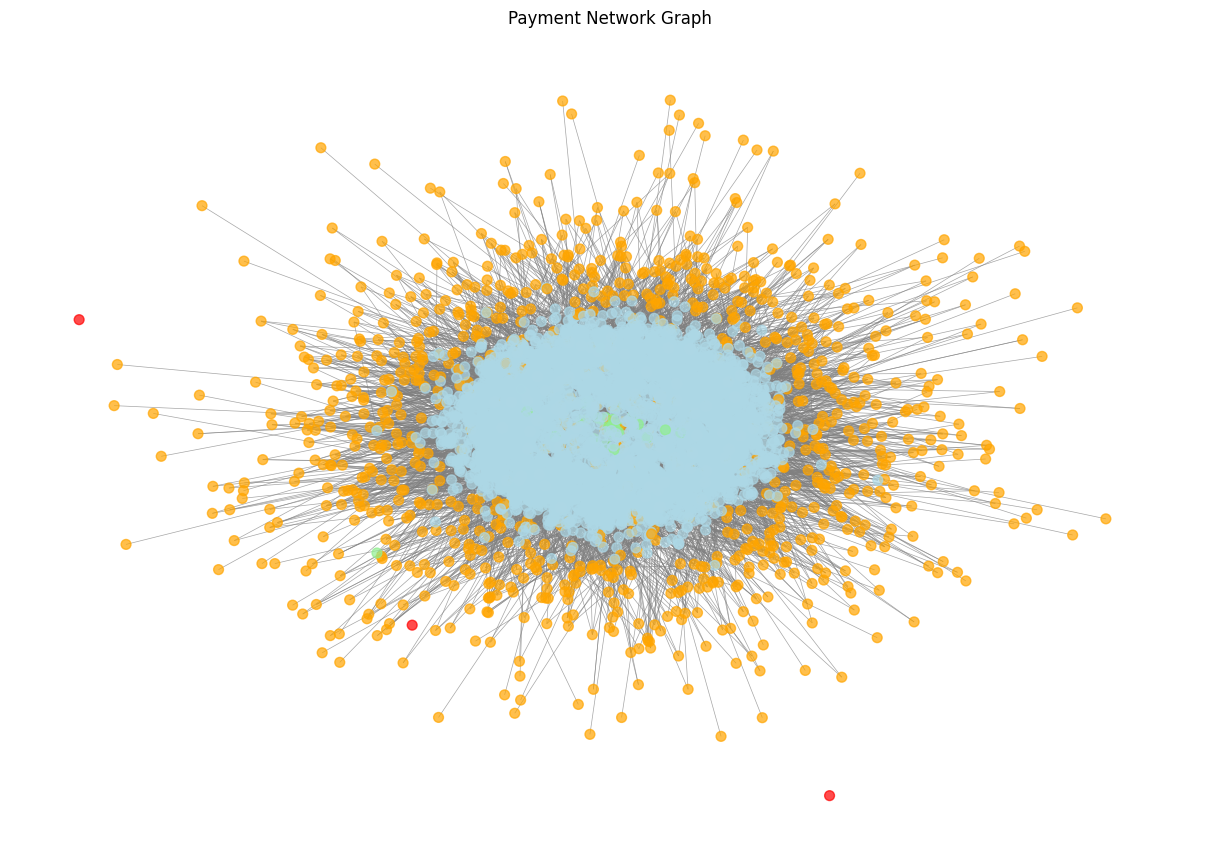

In [12]:
import matplotlib.pyplot as plt

# Create a simple visualization
plt.figure(figsize=(12, 8))

# Color nodes by type
color_map = {
    'user': 'lightblue',
    'merchant': 'lightgreen', 
    'device': 'orange',
    'psp': 'red'
}

node_colors = [color_map.get(G.nodes[node].get('type'), 'gray') for node in G.nodes()]

# Draw the graph
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw(G, pos, node_color=node_colors, node_size=50, alpha=0.7, 
        with_labels=False, edge_color='gray', width=0.5)

plt.title("Payment Network Graph")
plt.show()